### Clasificacion de Cultivos:
- 1 : Analisis y preparacion de datos
- 2 : Google Earth Engine
- 3 : Entrenamiento y evaluacion del Modelo 

### Etapa 1 : Analisis y preparacion de datos

En esta etapa se carga el archivo de train y test, se realiza un se lo prepara para el muestreo en GEE tomando puntos alrededor del punto central dado por el dataset, de este modo reducimos la tasa de error de muestreo. Se toman 12 puntos en forma de parche a partir del punto central. Se los etiqueta con el mismo Global ID para no perder la referencia del punto.
Ademas se generan dos datasets partidos a parte de los originales para realizar un entrenamiento previo y una evaluacion del modelo, para esto se parte el dataset de train en 70/30 como train_part y test_part respectivamente. 

In [19]:
import pandas as pd
import numpy as np

In [20]:
# Datasets de puntos de entrenamiento y test
dir_data_train = "C:/Users/Luciano/Desktop/Clasificacion de cultivos/datasets/data_train.csv"
dir_data_test = "C:/Users/Luciano/Desktop/Clasificacion de cultivos/datasets/data_test.csv"
# etiquetas de los cultivos
dir_etiquetas = "C:/Users/Luciano/Desktop/Clasificacion de cultivos/datasets/Etiquetas.csv"

In [21]:
data_train = pd.read_csv(dir_data_train,index_col='Id')
data_test = pd.read_csv(dir_data_test,index_col='Id')
etiquetas  = pd.read_csv(dir_etiquetas)#,index_col='CultivoId')

In [22]:
data_train.head()

Cultivo   Longitud    Latitud   Elevacion Dataset Campania  GlobalId
Id                                                                     
1        S -62.144163 -33.800202  104.111862      BC    18/19         1
4        M -62.155418 -33.801742  105.698082      BC    18/19         4
6        N -62.163615 -33.808092  104.233162      BC    18/19         6
7        M -62.164773 -33.813671  103.859932      BC    18/19         7
9        M -62.097200 -33.778628   98.532104      BC    18/19         9

In [23]:
data_train.shape

(850, 7)

In [24]:
data_test.shape

(555, 7)

In [25]:
etiquetas

CultivoId Cultivo                         Tipo
0           1       S                       SOJA 1
1           2       s                       SOJA 2
2           3       M                    MAIZ TEMP
3           4       m              MAIZ TARD O 2DA
4           5       T                        TRIGO
5           6       C                       CEBADA
6           7       G                      GIRASOL
7           8       R                        SORGO
8           9       P  FORRAJES, PASTURAS, VERDEOS
9          10       N                CAMPO NATURAL
10         11       B                     BARBECHO
11         12       O        OTROS CULTIVOS VERANO
12         13       o      OTROS CULTIVOS INVIERNO
13         14       E                        MONTE
14         15       A                         AGUA
15         16       g                     GARBANZO
16         17       t                        TOSCA
17         18       L                      LENTEJA
18         19      aa                      ALFALFA
19         20       V                        VICIA
20         21       c                      CENTENO
21         22       a                       ARVEJA
22         23       X                      NO SABE
23         24       U                       URBANO

In [26]:
# Separamos el dataset en campanias 18/19 y 19/20 para entrenar con imagenes que correspodan a cada periodo

data_train_18_19 = data_train[data_train.Campania =='18/19']

data_train_19_20 = data_train[data_train.Campania =='19/20']


data_test_18_19 = data_test[data_test.Campania =='18/19']

data_test_19_20 = data_test[data_test.Campania =='19/20']

In [27]:
print('Train 18/19 ',data_train_18_19.shape)
print('Train 19/20 ',data_train_19_20.shape)
print('Test 18/19 ',data_test_18_19.shape)
print('Train 19/20 ',data_test_19_20.shape)

Train 18/19  (294, 7)
Train 19/20  (556, 7)
Test 18/19  (228, 7)
Train 19/20  (327, 7)


In [37]:
data_train.Cultivo.value_counts()

S      344
M      210
s       89
N       82
P       55
X       34
U       12
R        6
B        6
m        4
T        2
aa       2
A        2
G        1
S/M      1
Name: Cultivo, dtype: int64

In [46]:
data_train_test = data_train[data_train.Cultivo != 'G']
data_train_test = data_train_test[data_train_test.Cultivo != 'S/M']

data_train_test.Cultivo.value_counts()

S     344
M     210
s      89
N      82
P      55
X      34
U      12
R       6
B       6
m       4
T       2
aa      2
A       2
Name: Cultivo, dtype: int64

In [47]:
######### para probar ########
# partimos el train para realizar una evaluacion previa del modelo, para el modelo final se entrena con el dataset completo
from sklearn.model_selection import train_test_split

data_train_part,data_test_part = train_test_split(data_train_test, test_size=0.3,random_state=0 , stratify = data_train_test.Cultivo)

#### Funcion para muestrear puntos cercanos al punto objetivo

La funcion para aumentar la cantidad de puntos lo que hace es tomar los puntos que rodean al punto central dado en el dataset de train. De esta forma se toma una muestra rectangular a partir de 12 puntos cercanos dentro del mismo cultivo. la distancia  entre punto y punto es de 60 metros 

In [48]:
def aumentar_puntos(data_train):
    data_train_au = data_train.copy() 
    for i in range(data_train.shape[0]):
        Longitud_ = data_train.iloc[i].Longitud
        Latitud_ = data_train.iloc[i].Latitud

        Longitud = Longitud_ - 0.00035
        Latitud = Latitud_ - 0.00035
        Longitud2 = Longitud_ + 0.00035
        Latitud2 = Latitud_ + 0.00035
        Longitud3 = Longitud_ - 0.00015
        Latitud3 = Latitud_ - 0.00015
        Longitud4 = Longitud_ + 0.00015
        Latitud4 = Latitud_ + 0.00015

        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud , 'Latitud' :Latitud ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud2 , 'Latitud' :Latitud2 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud , 'Latitud' :Latitud2 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud2 , 'Latitud' :Latitud ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)

        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud_ , 'Latitud' :Latitud ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud , 'Latitud' :Latitud_ ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud2 , 'Latitud' :Latitud_ ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud_ , 'Latitud' :Latitud2 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)  
        
        
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud3 , 'Latitud' :Latitud3 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud4 , 'Latitud' :Latitud4 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud3 , 'Latitud' :Latitud4 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
        data_train_au=data_train_au.append({'Cultivo' : data_train.iloc[i].Cultivo, 'Longitud' : Longitud4 , 'Latitud' :Latitud3 ,
                                  'Elevacion': data_train.iloc[i].Elevacion, 'Dataset' : data_train.iloc[i].Dataset,
                                  'Campania' : data_train.iloc[i].Campania, 'GlobalId':data_train.iloc[i].GlobalId} , ignore_index=True)
    
    
    return data_train_au

#### Por cada punto de entrenamiento y de test agregamos puntos alrededor

Preparamos los datasets que van a ser utilizados para el entrenamiento final y el testeo que luego sera el definitivo

In [49]:
# Se agregan 12 puntos alrededor del punto central

data_train_au = aumentar_puntos(data_train)

data_test_au = aumentar_puntos(data_test)

In [50]:
data_train_au.shape

(11050, 7)

In [51]:
data_test_au.shape

(7215, 7)

In [52]:
data_train_au = data_train_au.sort_values(by=['GlobalId'],ascending=True)
data_test_au = data_test_au.sort_values(by=['GlobalId'],ascending=True)

In [53]:
# Los datos aumentados tienen la forma:
data_train_au.head(15)

Cultivo   Longitud    Latitud   Elevacion Dataset Campania  GlobalId
0         S -62.144163 -33.800202  104.111862      BC    18/19         1
852       S -62.144513 -33.799852  104.111862      BC    18/19         1
853       S -62.143813 -33.800552  104.111862      BC    18/19         1
854       S -62.144163 -33.800552  104.111862      BC    18/19         1
855       S -62.144513 -33.800202  104.111862      BC    18/19         1
856       S -62.143813 -33.800202  104.111862      BC    18/19         1
857       S -62.144163 -33.799852  104.111862      BC    18/19         1
858       S -62.144313 -33.800352  104.111862      BC    18/19         1
859       S -62.144013 -33.800052  104.111862      BC    18/19         1
860       S -62.144313 -33.800052  104.111862      BC    18/19         1
861       S -62.144013 -33.800352  104.111862      BC    18/19         1
851       S -62.143813 -33.799852  104.111862      BC    18/19         1
850       S -62.144513 -33.800552  104.111862      BC    18/19         1
871       M -62.155268 -33.801592  105.698082      BC    18/19         4
873       M -62.155268 -33.801892  105.698082      BC    18/19         4

In [54]:
# Los datos del TEST
data_test_au

Cultivo   Longitud    Latitud   Elevacion Dataset Campania  GlobalId
0         NaN -62.150971 -33.797816  104.111862      BC    18/19         2
557       NaN -62.151321 -33.797466  104.111862      BC    18/19         2
558       NaN -62.150621 -33.798166  104.111862      BC    18/19         2
559       NaN -62.150971 -33.798166  104.111862      BC    18/19         2
560       NaN -62.151321 -33.797816  104.111862      BC    18/19         2
...       ...        ...        ...         ...     ...      ...       ...
7203      NaN -62.113242 -33.832594   -0.000023     BCR    19/20      1454
7213      NaN -62.113042 -33.832094   -0.000023     BCR    19/20      1454
554       NaN -62.112892 -33.832244   -0.000023     BCR    19/20      1454
7207      NaN -62.112892 -33.832594   -0.000023     BCR    19/20      1454
7214      NaN -62.112742 -33.832394   -0.000023     BCR    19/20      1454

[7215 rows x 7 columns]

In [69]:
data_train_18_19 = data_train_au[data_train_au.Campania =='18/19']
data_test_18_19 = data_test_au[data_test_au.Campania =='18/19']

data_train_19_20 = data_train_au[data_train_au.Campania =='19/20']
data_test_19_20 = data_test_au[data_test_au.Campania =='19/20']

**Realizamos la misma tarea para los puntos del dataset partido que se utilizara seleccion y evaluacion previa del modelo a utilizar luego para la prediccion final donde se vuelve a entrenar el mismo modelo pero con el dataset de train completo**

In [70]:
# Se agregan 12 puntos alrededor del punto central en los datos para evaluacion previa de los modelos

data_train_part_au = aumentar_puntos(data_train_part)

data_test_part_au = aumentar_puntos(data_test_part)

In [71]:
data_train_part_au = data_train_part_au.sort_values(by=['GlobalId'],ascending=True)
data_test_part_au = data_test_part_au.sort_values(by=['GlobalId'],ascending=True)

**Divimos los datasets de las campanias 18/19 y 19/20 ya que las mismas seran muestreadas de distintas imagenes satelitales, cada cual con la imagen correspondiente a su respectivo periodo ya que puede darse que los cultivos cambien de una campania a otra en una misma localizacion.** 

In [76]:
# para el dataset de evaluacion previa

data_train_part_18_19 = data_train_part_au[data_train_part_au.Campania =='18/19']

data_train_part_19_20 = data_train_part_au[data_train_part_au.Campania =='19/20']


data_test_part_18_19 = data_test_part_au[data_test_part_au.Campania =='18/19']

data_test_part_19_20 = data_test_part_au[data_test_part_au.Campania =='19/20']

In [77]:
data_train_part_18_19.shape

(2626, 7)

In [79]:
data_train_18_19.shape

(3822, 7)

**Por ultimo exportamos los datos procesados en archivos CSV para luego utilizarlos en GEE**

In [80]:
# Exportamos como CSV los datos para cargarlos en GEE
data_train_18_19.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_train_18_19.csv',index=True, index_label='Id' )
data_train_19_20.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_train_19_20.csv',index=True, index_label='Id' )

data_test_18_19.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_test_18_19.csv',index=True, index_label='Id' )
data_test_19_20.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_test_19_20.csv',index=True, index_label='Id' )

In [81]:
# Exportamos como CSV los datos para realizar la preevaluacion del modelo
data_train_part_18_19.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_train_part_18_19.csv',index=True, index_label='Id' )
data_train_part_19_20.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_train_part_19_20.csv',index=True, index_label='Id' )

data_test_part_18_19.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_test_part_18_19.csv',index=True, index_label='Id' )
data_test_part_19_20.to_csv('C:/Users/Luciano/Desktop/C_Cultivos/datasets/final/data_test_part_19_20.csv',index=True, index_label='Id' )

### Etapa 2 : GEE

**En esta etapa se cargan las respectivas imagenes satelitales correspondientes a cada periodo o campania. Se toman un conjunto de imagenes del satelite LANDSAT 8 correspondientes al poligono dado como objetivo. El conjunto de imagenes tomadas responde al periodo desde que se comienza la siembra de verano hasta la cosecha. Se realiza el muestreo de las imagenes por separado (Campania 18/19 y Campania 19/20)**

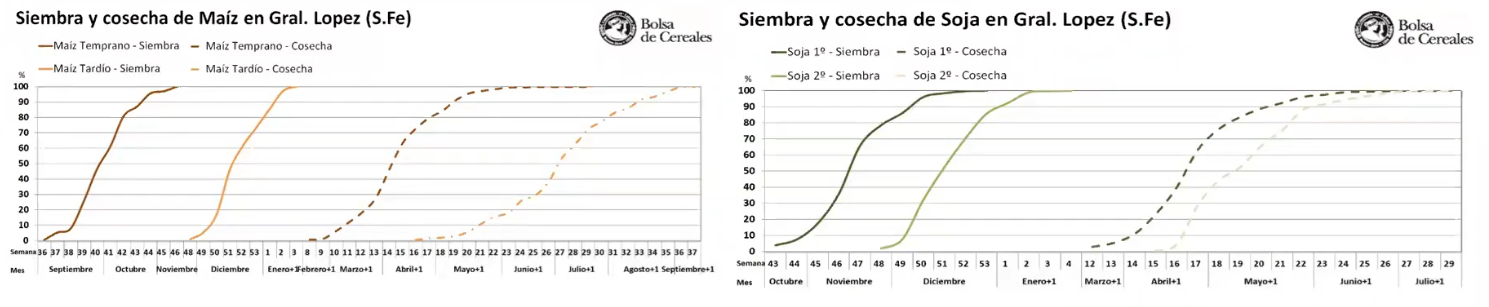

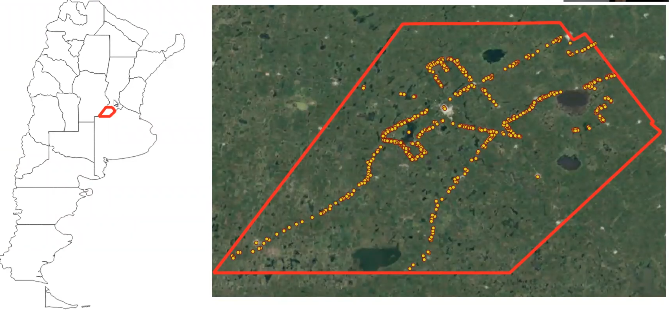

In [82]:
import geemap
import ee
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
Map = geemap.Map(center=[-33.871,-61.9077],zoom=8)

In [84]:
# Funcion para filtrar nubes

def filtrar_nubes(imagen):
    pixel_qa = imagen.select('pixel_qa')
    # pixel_qa contiene informacion respecto a las nubes (10 bits)
    #bit 3: cloud Shadow, bit 5: Cloud , bit 7: Cloud Confidence, bit 9: cirrus confidense
    mascara = 1010101000
    mascara_dec = int(str(mascara), 2)
    mask = pixel_qa.bitwiseAnd(mascara_dec)
    # Retornamos los valores que no son nubes ni relacionados con nubes
    return imagen.updateMask(mask.eq(0))

In [85]:
# Funcion para calcular el NDVI y SAVI

def calcular_indices(img):
    return img \
            .addBands( img.normalizedDifference(["B5" , "B4"]).multiply(10000).rename("NDVI")) \
            .addBands( img.expression( "((NIR - R) / (NIR + R + L)) * (1+L)",
                  { 'NIR': img.select("B5"),
                    'R': img.select("B4"),
                    'L': 0.5 }).multiply(10000).rename("SAVI"))

In [86]:
# Cargamos el poligono y los puntos guardados como assets en GEE

zona_estudio = ee.FeatureCollection('users/lnperoni/zona_studio')

# Puntos de train y test cargados como assets en GEE a partir de los CSV generados anteriormente

p_train_18_19 = ee.FeatureCollection('users/lnperoni/data_train_18_19')
p_test_18_19 = ee.FeatureCollection('users/lnperoni/data_test_18_19')

p_train_19_20 = ee.FeatureCollection('users/lnperoni/data_train_19_20')
p_test_19_20 = ee.FeatureCollection('users/lnperoni/data_test_19_20')

# Datasets de evaluacion del modelo

p_eval_train_18_19 = ee.FeatureCollection('users/lnperoni/data_train_part_18_19')
p_eval_test_18_19 = ee.FeatureCollection('users/lnperoni/data_test_part_18_19')

p_eval_train_19_20 = ee.FeatureCollection('users/lnperoni/data_train_part_19_20')
p_eval_test_19_20 = ee.FeatureCollection('users/lnperoni/data_test_part_19_20')


### Campania 18/19

In [87]:
# Cargamos la coleccion de imagenes del 18/19

Landsat8_18_19 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
Landsat8_18_19 = Landsat8_18_19.filterBounds(zona_estudio)
Landsat8_18_19 = Landsat8_18_19.filterMetadata("CLOUD_COVER", "less_than", 30)
Landsat8_18_19 = Landsat8_18_19.filterDate("2018-08-01","2019-03-20" )

print("Cantidad de escenas: ",Landsat8_18_19.size().getInfo())

Cantidad de escenas:  40


In [88]:
# Filtramos las nubes
Landsat8_18_19 = Landsat8_18_19.map(filtrar_nubes)

In [89]:
Map.addLayer(Landsat8_18_19, {'gain': [0.15,0.15,0.1],'bands': ["B4","B3","B2"]}, "Landsat8_18_19")
Map.addLayer(zona_estudio,{},'Gral.Lopez', True)
Map.addLayer(p_train_18_19,{'color': "red"},'train_18_19')
Map.addLayer(p_test_18_19,{'color': "blue"},'test_18_19')
Map

Map(center=[-33.871, -61.9077], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

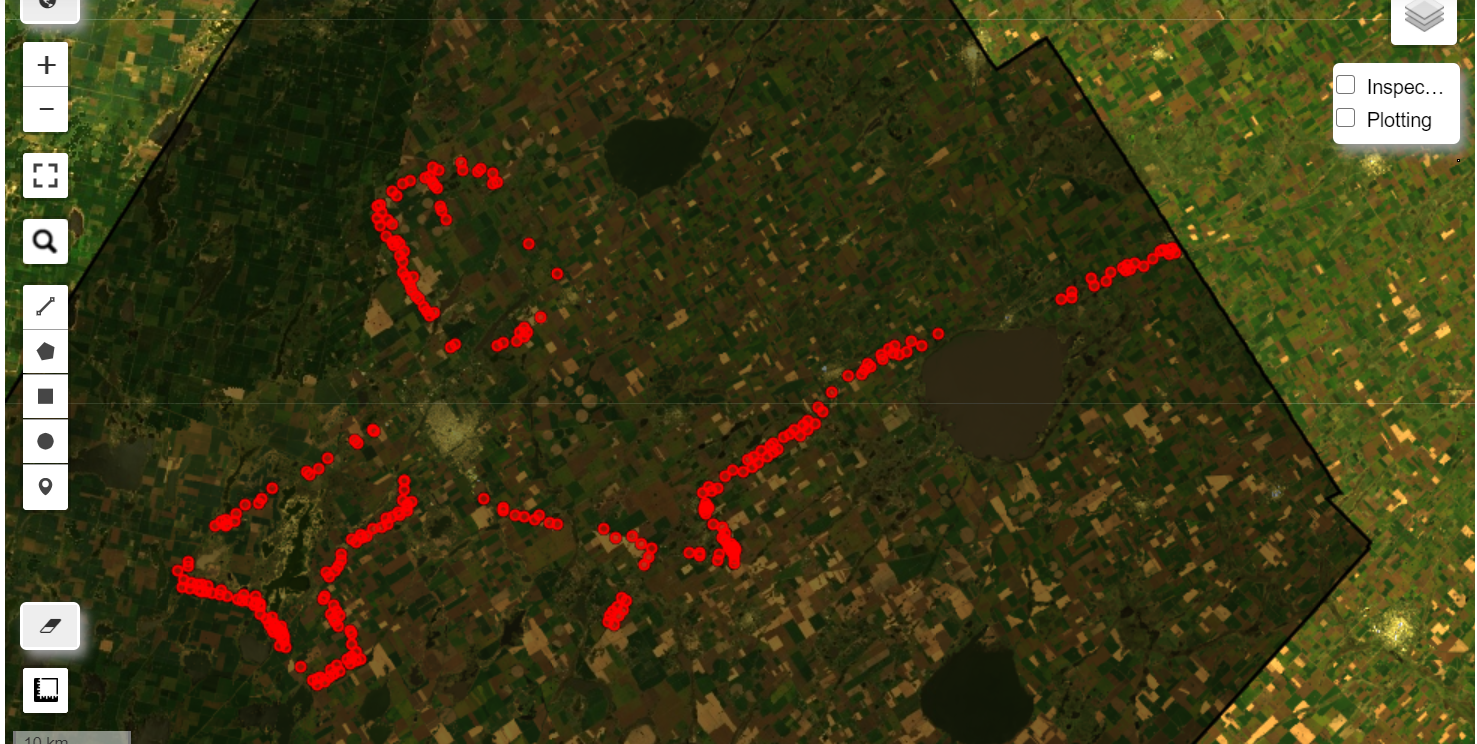

Cada cultivo etiquetado tiene una muestra total de 13, el punto central esta dado por el dataset original de train y luego se toman 12  puntos cercanos.

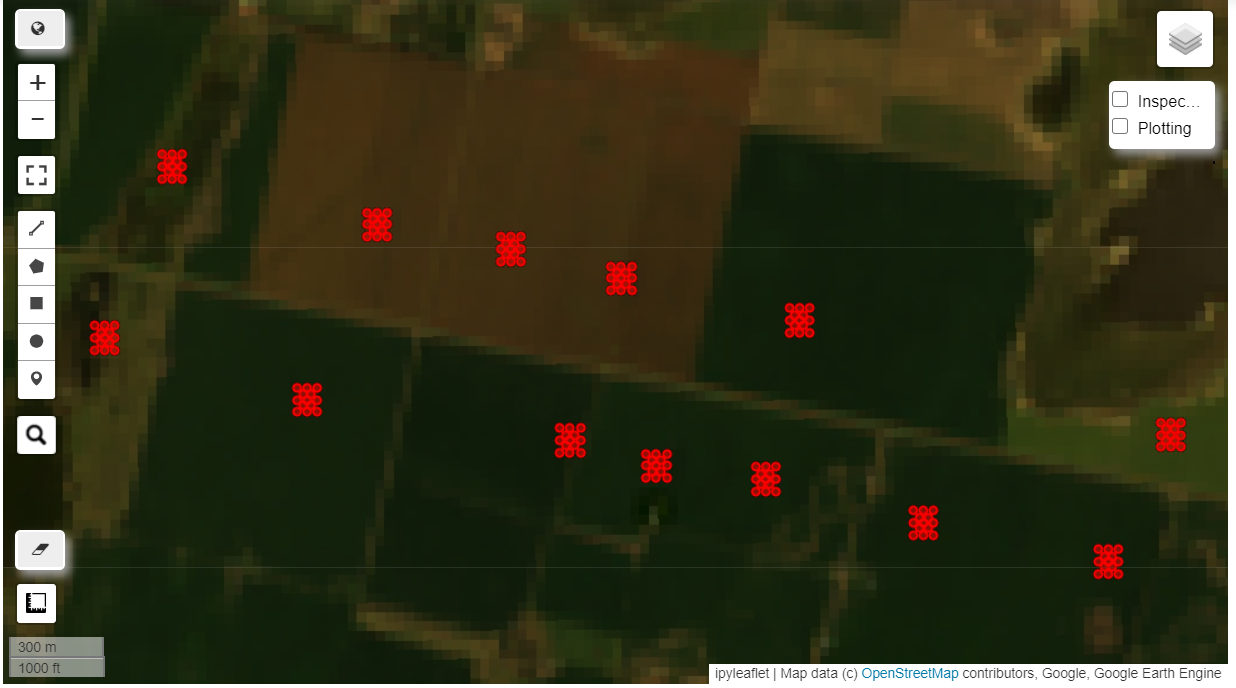

In [90]:
# Calculamos el NDVI y SAVI
Landsat8_18_19 = Landsat8_18_19.map(calcular_indices)

In [91]:
# Seleccionamos las bandas que nos interesan y calculamos las estadisticas de la coleccion de imagenes por cada banda

bandas = ["B2","B3","B4","B5", "B6","B7","NDVI", "SAVI"]
Landsat8_18_19 = Landsat8_18_19.select(bandas)

mediana_18_19 = Landsat8_18_19.reduce(ee.Reducer.median()).toInt()
media_18_19 = Landsat8_18_19.reduce(ee.Reducer.mean()).toInt()
min_18_19 = Landsat8_18_19.reduce(ee.Reducer.min()).toInt()
max_18_19 = Landsat8_18_19.reduce(ee.Reducer.max()).toInt()
std_18_19 = Landsat8_18_19.reduce(ee.Reducer.stdDev()).toInt()
amplitud_18_19 = max_18_19.subtract(min_18_19).toInt()

Luego de seleccionar las bandas utiles lo que hacemos es calcular la media, mediana, desvacion, maximos, minimos y amplitud de cada coleccion de imagenes correspondientes a un peridodo determinado, de este modo podemos diferenciar cada cultivo y las demas clases como barbecho o agua. Por ejemplo, analizando la desviacion de la coleccion podemos ver los lugares donde estan situados los cultivos respecto de las pasturas o barbecho que no cambian en relacion al tiempo. Ver grafica de bandas en la etapa de entrenamiento. 

In [94]:
# Generamos un feature space con las bandas calculadas anteriormente

feature_space_18_19 =   mediana_18_19.addBands(media_18_19)\
                                     .addBands(min_18_19)\
                                     .addBands(max_18_19)\
                                     .addBands(std_18_19)\
                                     .addBands(amplitud_18_19)

Luego de calcular las bandas que nos interesan con sus respectivos valores tenemos un feature_space que contiene las difentes bandas con sus valores (max min std median.. etc), lo que hacemos es tomar muestras de los puntos de cada cultivo de esta hipermatriz. La siguiente funcion nos retorna el valor de los puntos con la etiqueta del cultivo al que pertenecen y su respectivo GlobalId. 

In [95]:
s_p_train_18_19 = feature_space_18_19.sampleRegions(**{
                                  'collection': p_train_18_19,
                                  'properties': ["Cultivo","GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [96]:
s_p_test_18_19 = feature_space_18_19.sampleRegions(**{
                                  'collection': p_test_18_19,
                                  'properties': ["GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [42]:
# Tomamos las muestras para los datasets de evaluacion

Relizamos la misma tarea para los datasets partidos que utilizaremos para realizar una evaluacion previa del metodo y de los modelos. 

In [124]:
s_p_eval_train_18_19 = feature_space_18_19.sampleRegions(**{
                                  'collection': p_eval_train_18_19,
                                  'properties': ["Cultivo","GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [125]:
s_p_eval_test_18_19 = feature_space_18_19.sampleRegions(**{
                                  'collection': p_eval_test_18_19,
                                  'properties': ["Cultivo","GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [45]:
# Exportamos las muestras tomadas a un CSV en drive para procesarlo 

Una vez tomadas las muestras, para no tener que realizar nuevamente la tarea de muestreo y por una cuestion de simplicidad, exportamos las muestras a un CSV que luego utilizaremos para entrenar el modelo. 

In [99]:
# Dataset de train 18/19
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_train_18_19,
  'description':'s_p_train_18_19',
  'fileFormat': 'CSV'
})

In [100]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: XGMQ5Z44I3MLCLSZR5QFGPVL).
Guardando dataset en Drive (id: XGMQ5Z44I3MLCLSZR5QFGPVL).
Guardando dataset en Drive (id: XGMQ5Z44I3MLCLSZR5QFGPVL).


In [101]:
# Dataset de test 18/19
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_test_18_19,
  'description':'s_p_test_18_19',
  'fileFormat': 'CSV'
})

In [102]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: JIBI2ETIAM5TW2KRQFKNLB5W).
Guardando dataset en Drive (id: JIBI2ETIAM5TW2KRQFKNLB5W).
Guardando dataset en Drive (id: JIBI2ETIAM5TW2KRQFKNLB5W).
Guardando dataset en Drive (id: JIBI2ETIAM5TW2KRQFKNLB5W).
Guardando dataset en Drive (id: JIBI2ETIAM5TW2KRQFKNLB5W).
Guardando dataset en Drive (id: JIBI2ETIAM5TW2KRQFKNLB5W).


In [126]:
# Dataset de evaluacion train 18/19
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_eval_train_18_19,
  'description':'s_p_eval_train_18_19',
  'fileFormat': 'CSV'
})

In [127]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: 23P4SD7S2YHYZED4NKOQHA6I).
Guardando dataset en Drive (id: 23P4SD7S2YHYZED4NKOQHA6I).
Guardando dataset en Drive (id: 23P4SD7S2YHYZED4NKOQHA6I).


In [128]:
# Dataset de evaluacion test 18/19
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_eval_test_18_19,
  'description':'s_p_eval_test_18_19',
  'fileFormat': 'CSV'
})

In [129]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: V55BVQHEHHO5UCKPO77FM5SL).
Guardando dataset en Drive (id: V55BVQHEHHO5UCKPO77FM5SL).


### Repetimos el proceso para la campania 19/20 

In [103]:
# Cargamos la coleccion de imagenes del 19/20

Landsat8_19_20 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
Landsat8_19_20 = Landsat8_19_20.filterBounds(zona_estudio)
Landsat8_19_20 = Landsat8_19_20.filterMetadata("CLOUD_COVER", "less_than", 30)
Landsat8_19_20 = Landsat8_19_20.filterDate("2019-08-01","2020-03-20" )

print("Cantidad de escenas: ",Landsat8_19_20.size().getInfo())

Cantidad de escenas:  26


In [104]:
# Filtramos las nubes
Landsat8_19_20 = Landsat8_19_20.map(filtrar_nubes)

In [105]:
Map2 = geemap.Map(center=[-33.871,-61.9077],zoom=8)
Map2.addLayer(Landsat8_19_20, {'gain': [0.15,0.15,0.1],'bands': ["B4","B3","B2"]}, "Landsat8_19_20")
Map2.addLayer(zona_estudio,{},'Gral.Lopez', True)
Map2.addLayer(p_train_19_20,{'color': "red"},'train_19_20')
Map2.addLayer(p_test_19_20,{'color': "blue"},'test_19_20')
Map2

Map(center=[-33.871, -61.9077], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

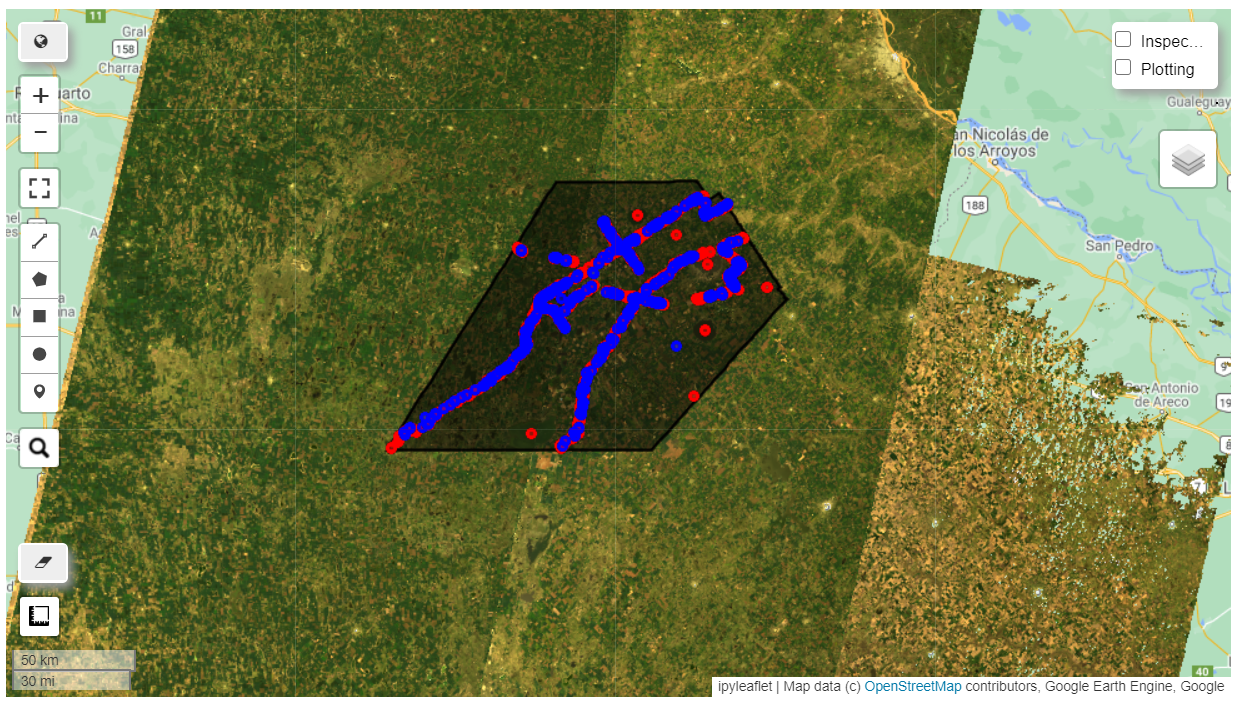

In [106]:
# Calculamos el NDVI y SAVI
Landsat8_19_20 = Landsat8_19_20.map(calcular_indices)

In [107]:
# Seleccionamos las bandas que nos interesan y calculamos las estadisticas de la coleccion de imagenes por cada banda

bandas = ["B2","B3","B4","B5", "B6","B7","NDVI", "SAVI"]
Landsat8_19_20 = Landsat8_19_20.select(bandas)

mediana_19_20 = Landsat8_19_20.reduce(ee.Reducer.median()).toInt()
media_19_20 = Landsat8_19_20.reduce(ee.Reducer.mean()).toInt()
min_19_20 = Landsat8_19_20.reduce(ee.Reducer.min()).toInt()
max_19_20 = Landsat8_19_20.reduce(ee.Reducer.max()).toInt()
std_19_20 = Landsat8_19_20.reduce(ee.Reducer.stdDev()).toInt()
amplitud_19_20 = max_19_20.subtract(min_18_19).toInt()

In [108]:
# Generamos un feature space con las bandas calculadas anteriormente

feature_space_19_20 =   mediana_19_20.addBands(media_19_20)\
                                     .addBands(min_19_20)\
                                     .addBands(max_19_20)\
                                     .addBands(std_19_20)\
                                     .addBands(amplitud_19_20)

In [109]:
s_p_train_19_20 = feature_space_19_20.sampleRegions(**{
                                  'collection': p_train_19_20,
                                  'properties': ["Cultivo","GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [110]:
s_p_test_19_20 = feature_space_19_20.sampleRegions(**{
                                  'collection': p_test_19_20,
                                  'properties': ["GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [ ]:
# Tomamos las muestras para los datasets de evaluacion

In [111]:
s_p_eval_train_19_20 = feature_space_19_20.sampleRegions(**{
                                  'collection': p_eval_train_19_20,
                                  'properties': ["Cultivo","GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [112]:
s_p_eval_test_19_20 = feature_space_19_20.sampleRegions(**{
                                  'collection': p_eval_test_19_20,
                                  'properties': ["Cultivo","GlobalId"],
                                  'scale': 30,
                                  'tileScale': 2,
                                  'geometries': True  } )

In [ ]:
# Exportamos las muestras tomadas a un CSV en drive para procesarlo 

In [113]:
# Dataset de train 19/20
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_train_19_20,
  'description':'s_p_train_19_20',
  'fileFormat': 'CSV'
})

In [114]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: 5VRLISCWTAVMW7WC75BJ4I4S).
Guardando dataset en Drive (id: 5VRLISCWTAVMW7WC75BJ4I4S).
Guardando dataset en Drive (id: 5VRLISCWTAVMW7WC75BJ4I4S).


In [115]:
# Dataset de test 19/20
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_test_19_20,
  'description':'s_p_test_19_20',
  'fileFormat': 'CSV'
})

In [116]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: T3R2PXJVIPY5EGQMRWEBDYG2).
Guardando dataset en Drive (id: T3R2PXJVIPY5EGQMRWEBDYG2).
Guardando dataset en Drive (id: T3R2PXJVIPY5EGQMRWEBDYG2).
Guardando dataset en Drive (id: T3R2PXJVIPY5EGQMRWEBDYG2).
Guardando dataset en Drive (id: T3R2PXJVIPY5EGQMRWEBDYG2).


In [117]:
# Dataset de evaluacion train 19/20
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_eval_train_19_20,
  'description':'s_p_eval_train_19_20',
  'fileFormat': 'CSV'
})

In [118]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: 7POJM7PLK4CIAMRJOBZWZIYO).
Guardando dataset en Drive (id: 7POJM7PLK4CIAMRJOBZWZIYO).
Guardando dataset en Drive (id: 7POJM7PLK4CIAMRJOBZWZIYO).
Guardando dataset en Drive (id: 7POJM7PLK4CIAMRJOBZWZIYO).
Guardando dataset en Drive (id: 7POJM7PLK4CIAMRJOBZWZIYO).


In [119]:
# Dataset de evaluacion test 19/20
task = ee.batch.Export.table.toDrive(**{
  'collection': s_p_eval_test_19_20,
  'description':'s_p_eval_test_19_20',
  'fileFormat': 'CSV'
})

In [120]:
task.start()

while task.active():
  print('Guardando dataset en Drive (id: {}).'.format(task.id))
  time.sleep(10)

Guardando dataset en Drive (id: VFKMLHBGYW2VNJI7TADPZC5A).
Guardando dataset en Drive (id: VFKMLHBGYW2VNJI7TADPZC5A).
Guardando dataset en Drive (id: VFKMLHBGYW2VNJI7TADPZC5A).


### Entrenamiento del Modelo 

In [121]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import statistics as stat

In [122]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# Cargamos los CSV con los datos de los muestreo de los puntos en las imagenes satelitales

In [123]:
# Dataset de train y test 18/19
s_p_train_18_19 = pd.read_csv('content/Drive/final/s_p_train_18_19.csv')
s_p_test_18_19 = pd.read_csv('content/Drive/final/s_p_test_18_19.csv')

# Dataset de train y test 19/20
s_p_train_19_20 = pd.read_csv('content/Drive/final/s_p_train_19_20.csv')
s_p_test_19_20 = pd.read_csv('content/Drive/final/s_p_test_19_20.csv')

In [178]:
# Datasets para la evaluacion de los modelos
# Dataset de train y test 18/19
s_p_eval_train_18_19 = pd.read_csv('content/Drive/final/s_p_eval_train_18_19.csv')
s_p_eval_test_18_19 = pd.read_csv('content/Drive/final/s_p_eval_test_18_19.csv')

# Dataset de train y test 19/20
s_p_eval_train_19_20 = pd.read_csv('content/Drive/s_p_eval_train_19_20.csv')
s_p_eval_test_19_20 = pd.read_csv('content/Drive/s_p_eval_test_19_20.csv')

In [131]:
print('dimensiones de s_p_eval_train_18_19 : ',s_p_eval_train_18_19.shape)
print('dimensiones de s_p_eval_test_18_19 : ',s_p_eval_test_18_19.shape)
print('dimensiones de s_p_eval_train_19_20 : ',s_p_eval_train_19_20.shape)
print('dimensiones de s_p_eval_test_19_20 : ',s_p_eval_test_19_20.shape)

dimensiones de s_p_eval_train_18_19 :  (2626, 52)
dimensiones de s_p_eval_test_18_19 :  (1170, 52)
dimensiones de s_p_eval_train_19_20 :  (5070, 52)
dimensiones de s_p_eval_test_19_20 :  (2140, 52)


### Modelo campania 18/19 ( validation )

In [132]:
s_p_eval_train_18_19

system:index  B2_max  B2_max_1  B2_mean  B2_median  B2_min  \
0     00000000000000000740_0    1124      1011      528        477     113   
1     00000000000000000741_0     714       558      355        339     156   
2     00000000000000000742_0    1124      1011      528        477     113   
3     00000000000000000743_0     558       462      279        280      96   
4     00000000000000000744_0     484       379      313        297     105   
...                      ...     ...       ...      ...        ...     ...   
2621  000000000000000000fc_0     544       318      347        315     226   
2622  000000000000000000fd_0     548       321      348        323     227   
2623  000000000000000000fe_0     529       300      346        324     229   
2624  000000000000000000ff_0     553       314      358        331     239   
2625  00000000000000000100_0     544       318      347        315     226   

      B2_stdDev  B3_max  B3_max_1  B3_mean  ...  NDVI_median  NDVI_min  \
0           266    1573      1244      852  ...         2703      1647   
1           158    1138       812      605  ...         4109      3057   
2           266    1573      1244      852  ...         2703      1647   
3           139     839       679      440  ...         3848      2651   
4           105     872       590      539  ...         4033      1893   
...         ...     ...       ...      ...  ...          ...       ...   
2621        115     803       294      650  ...         7897      4145   
2622        116     798       283      650  ...         7731      4115   
2623        109     786       273      647  ...         7611      4248   
2624        115     818       297      662  ...         7737      4061   
2625        115     803       294      650  ...         7897      4145   

      NDVI_stdDev  SAVI_max  SAVI_max_1  SAVI_mean  SAVI_median  SAVI_min  \
0            1331      9199        6728       4976         4054      2471   
1            1143      9804        5218       6461         6163      4586   
2            1331      9199        6728       4976         4054      2471   
3            1123      9254        5278       6221         5770      3976   
4            1322      9403        6564       5824         6049      2839   
...           ...       ...         ...        ...          ...       ...   
2621         1606     13372        7155      10987        11845      6217   
2622         1563     13240        7068      10852        11596      6172   
2623         1444     13011        6640      10759        11415      6371   
2624         1671     13307        7217      10792        11604      6090   
2625         1606     13372        7155      10987        11845      6217   

      SAVI_stdDev                                               .geo  
0            1996  {"geodesic":false,"type":"Point","coordinates"...  
1            1714  {"geodesic":false,"type":"Point","coordinates"...  
2            1996  {"geodesic":false,"type":"Point","coordinates"...  
3            1684  {"geodesic":false,"type":"Point","coordinates"...  
4            1982  {"geodesic":false,"type":"Point","coordinates"...  
...           ...                                                ...  
2621         2410  {"geodesic":false,"type":"Point","coordinates"...  
2622         2345  {"geodesic":false,"type":"Point","coordinates"...  
2623         2167  {"geodesic":false,"type":"Point","coordinates"...  
2624         2507  {"geodesic":false,"type":"Point","coordinates"...  
2625         2410  {"geodesic":false,"type":"Point","coordinates"...  

[2626 rows x 52 columns]

In [133]:
s_p_eval_train_18_19.columns

Index(['system:index', 'B2_max', 'B2_max_1', 'B2_mean', 'B2_median', 'B2_min',
       'B2_stdDev', 'B3_max', 'B3_max_1', 'B3_mean', 'B3_median', 'B3_min',
       'B3_stdDev', 'B4_max', 'B4_max_1', 'B4_mean', 'B4_median', 'B4_min',
       'B4_stdDev', 'B5_max', 'B5_max_1', 'B5_mean', 'B5_median', 'B5_min',
       'B5_stdDev', 'B6_max', 'B6_max_1', 'B6_mean', 'B6_median', 'B6_min',
       'B6_stdDev', 'B7_max', 'B7_max_1', 'B7_mean', 'B7_median', 'B7_min',
       'B7_stdDev', 'Cultivo', 'GlobalId', 'NDVI_max', 'NDVI_max_1',
       'NDVI_mean', 'NDVI_median', 'NDVI_min', 'NDVI_stdDev', 'SAVI_max',
       'SAVI_max_1', 'SAVI_mean', 'SAVI_median', 'SAVI_min', 'SAVI_stdDev',
       '.geo'],
      dtype='object')

In [134]:
s_p_eval_train_18_19.GlobalId.nunique()

202

In [135]:
# Copiamos el target y lo quitamos del dataset de entrenamiento

# Train
y_tr_18_19 = s_p_eval_train_18_19.Cultivo

X_tr_18_19 = s_p_eval_train_18_19.drop(['system:index','Cultivo','.geo','GlobalId'],axis=1, inplace=False)

# validation
y_val_18_19 = s_p_eval_test_18_19.Cultivo

Global_id_18_19 = s_p_eval_test_18_19.GlobalId

X_val_18_19 = s_p_eval_test_18_19.drop(['system:index','Cultivo','.geo','GlobalId'],axis=1, inplace=False)

In [138]:
A = X_tr_18_19.loc[y_tr_18_19 =='A'].iloc[1]
M = X_tr_18_19.loc[y_tr_18_19 =='M'].iloc[1]
N = X_tr_18_19.loc[y_tr_18_19 =='N'].iloc[1]
S = X_tr_18_19.loc[y_tr_18_19 =='S'].iloc[1]
aa = X_tr_18_19.loc[y_tr_18_19 =='aa'].iloc[1]
P = X_tr_18_19.loc[y_tr_18_19 =='P'].iloc[1]

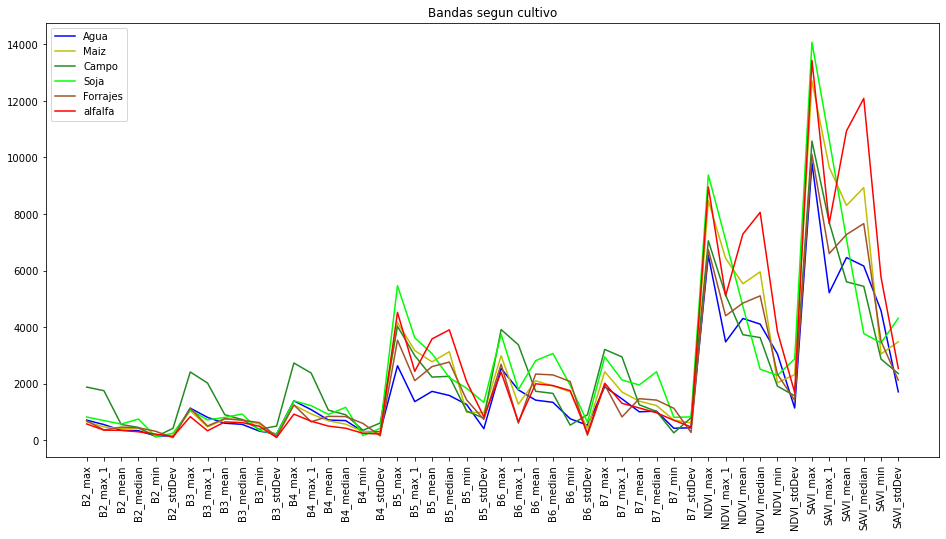

In [139]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(16,8))
plt.title('Bandas segun cultivo')
plt.plot(np.transpose(A),color='b')
plt.plot(np.transpose(M),color='y')
plt.plot(np.transpose(N),color='forestgreen')
plt.plot(np.transpose(S),color='lime')
plt.plot(np.transpose(P),color='sienna')
plt.plot(np.transpose(aa),color='red')
plt.xticks(rotation=90)
plt.legend(['Agua','Maiz','Campo','Soja','Forrajes','alfalfa'])
plt.show()

En la grafica observamos como se difencian las bandas segun el tipo de cultivo. Cada una de las estadisticas se tomaron de la coleccion de imagenes que corresponden a un determinado periodo (desde octubre hasta marzo) por lo que la evolucion de los cultivos y aquellos que permanecen sin cambios como las pasturas se ven reflejados en las desviaciones. 

In [140]:
# Codificamos a numeros la categorial del target y luego las pasamos a ONE-HOT Encoding

label_encoder = LabelEncoder()

y_tr_enc = label_encoder.fit_transform(y_tr_18_19)

y_tr_OHE = to_categorical(y_tr_enc)


In [141]:
# Normalizamos los datos de entrenamiento

min_max_scaler = preprocessing.MinMaxScaler()

X_tr_norm_18_19 = min_max_scaler.fit_transform(X_tr_18_19)

X_val_norm_18_19 = min_max_scaler.transform(X_val_18_19)

In [143]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(X_tr_18_19.shape[1],)))
    
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(y_tr_OHE.shape[1]))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

model = create_model()

metrics = [tf.keras.metrics.CategoricalAccuracy()]

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=metrics
)

history = model.fit(
    X_tr_norm_18_19.astype(np.float32), 
    y_tr_OHE.astype(np.float32),
    epochs=200,
    batch_size=128,
    #validation_data=(X_val_norm_18_19, ),
)

Train on 2626 samples
Epoch 1/200
2626/2626 [==============================] - 0s 174us/sample - loss: 1.5266 - categorical_accuracy: 0.4928
Epoch 2/200
2626/2626 [==============================] - 0s 21us/sample - loss: 1.1708 - categorical_accuracy: 0.6104
Epoch 3/200
2626/2626 [==============================] - 0s 21us/sample - loss: 1.0515 - categorical_accuracy: 0.6596
Epoch 4/200
2626/2626 [==============================] - 0s 24us/sample - loss: 0.9796 - categorical_accuracy: 0.6820
Epoch 5/200
2626/2626 [==============================] - 0s 24us/sample - loss: 0.9105 - categorical_accuracy: 0.7106
Epoch 6/200
2626/2626 [==============================] - 0s 24us/sample - loss: 0.8668 - categorical_accuracy: 0.7258
Epoch 7/200
2626/2626 [==============================] - 0s 23us/sample - loss: 0.8365 - categorical_accuracy: 0.7384
Epoch 8/200
2626/2626 [==============================] - 0s 23us/sample - loss: 0.8119 - categorical_accuracy: 0.7430
Epoch 9/200
2626/2626 [==========

2626/2626 [==============================] - 0s 22us/sample - loss: 0.1965 - categorical_accuracy: 0.9364
Epoch 138/200
2626/2626 [==============================] - 0s 23us/sample - loss: 0.1841 - categorical_accuracy: 0.9410
Epoch 139/200
2626/2626 [==============================] - 0s 21us/sample - loss: 0.1898 - categorical_accuracy: 0.9341
Epoch 140/200
2626/2626 [==============================] - 0s 20us/sample - loss: 0.1877 - categorical_accuracy: 0.9398
Epoch 141/200
2626/2626 [==============================] - 0s 21us/sample - loss: 0.1822 - categorical_accuracy: 0.9398
Epoch 142/200
2626/2626 [==============================] - 0s 22us/sample - loss: 0.1911 - categorical_accuracy: 0.9391
Epoch 143/200
2626/2626 [==============================] - 0s 21us/sample - loss: 0.1726 - categorical_accuracy: 0.9474
Epoch 144/200
2626/2626 [==============================] - 0s 22us/sample - loss: 0.1848 - categorical_accuracy: 0.9364
Epoch 145/200
2626/2626 [=============================

<AxesSubplot:>

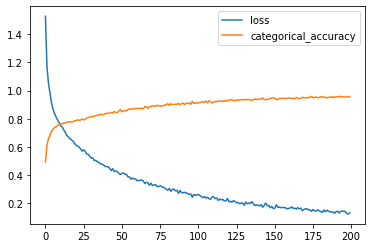

In [144]:
pd.DataFrame(history.history).plot()

In [145]:
y_pred =  model.predict_classes(X_val_norm_18_19)
label_predict = label_encoder.inverse_transform(y_pred)

**Luego para obtener las predicciones sobre cada cultivo obtenemos los puntos de cada GlobalID unico y calculamos la "moda"** 

In [148]:

predict_18_19 = []
n_muestras= 13
for i in range(0,int(label_predict.shape[0]/n_muestras)):
    print('i: {} : {} '.format(i,label_predict[i*n_muestras:i*n_muestras+n_muestras]))
    c_moda =  stat._counts(label_predict[i*n_muestras:i*n_muestras+n_muestras])
    len_moda = len(c_moda)
    if len_moda == 1:
        moda = stat.mode(label_predict[i*n_muestras:i*n_muestras+n_muestras])
    else:
        moda = c_moda[0][0]
        
    predict_18_19.append(moda)
    print('moda: ',moda)

i: 0 : ['S' 'M' 'S' 'M' 'S' 'M' 'M' 'S' 'S' 'S' 'S' 'M' 'M'] 
moda:  S
i: 1 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 2 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 3 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 4 : ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'] 
moda:  N
i: 5 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 6 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 7 : ['M' 'M' 'M' 'M' 'M' 'S' 'M' 'M' 'S' 'M' 'S' 'S' 'M'] 
moda:  M
i: 8 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 9 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 10 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 11 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 12 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 13 : ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'S' 'M' 'N' 'M' 'M' 'M'] 
moda:  N
i:

Se toma la moda de cada conjunto de puntos que corresponden al mismo GlobalID, de este modo evitamos errores por falta de informacion o por ubicaciones erroneas de las muestras. La resultante de esta operacion es la cantidad de puntos original antes de aumentar las muestas. 

In [150]:
y_val_list = []
for i in range(0,int(y_val_18_19.shape[0]/n_muestras)):
    #print('i: {} : {} '.format(i,y_val_18_19.iloc[i*n_muestras:i*n_muestras+n_muestras]))
    y_val_list.append(stat.mode(y_val_18_19.iloc[i*n_muestras:i*n_muestras+n_muestras]))

In [152]:
ac2 = balanced_accuracy_score(y_val_list,predict_18_19)
print('El Balanced Accuracy para los datos de campania 18/19 :',ac2)

El Balanced Accuracy para los datos de campania 18/19 : 0.6838993710691824


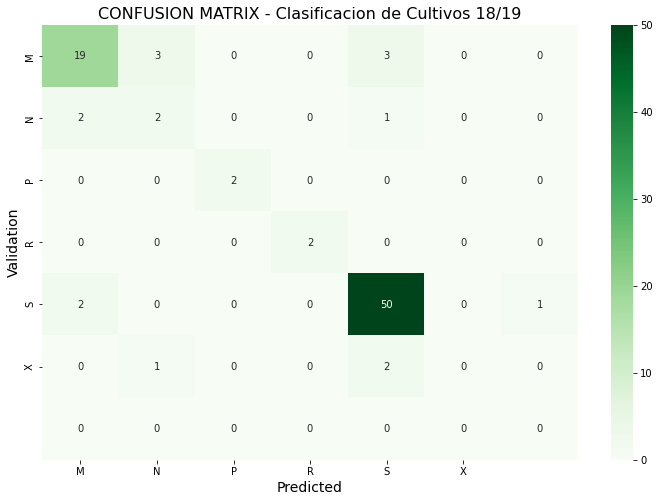

In [153]:
labels =np.unique(y_val_list)
conf_matrix = confusion_matrix(y_val_list,predict_18_19 )
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('Validation',size=14)
plt.xlabel('Predicted',size=14)
plt.title("CONFUSION MATRIX - Clasificacion de Cultivos 18/19", size=16);

### Modelo campania 19/20 ( validation )

In [179]:
# Copiamos el target y lo quitamos del dataset de entrenamiento

# Train
y_tr_19_20 = s_p_eval_train_19_20.Cultivo

X_tr_19_20 = s_p_eval_train_19_20.drop(['system:index','Cultivo','.geo','GlobalId'],axis=1, inplace=False)

# validation
y_val_19_20 = s_p_eval_test_19_20.Cultivo

Global_id_19_20 = s_p_eval_test_19_20.GlobalId

X_val_19_20 = s_p_eval_test_19_20.drop(['system:index','Cultivo','.geo','GlobalId'],axis=1, inplace=False)

In [180]:
X_tr_19_20

B10_max  B10_max_1  B10_mean  B10_median  B10_min  B10_stdDev  B11_max  \
0        3030         87      2999        3007     2961          26     3002   
1        3034        122      2987        2992     2919          39     3008   
2        3032         89      3000        3009     2963          25     3003   
3        3033        118      2997        3002     2956          30     3005   
4        3030        125      2995        3003     2952          30     3002   
...       ...        ...       ...         ...      ...         ...      ...   
5075     3050        102      3004        2982     2982          32     3008   
5076     3049        101      3005        2984     2983          30     3008   
5077     3050        101      3006        2985     2985          30     3008   
5078     3049        101      3005        2984     2984          30     3006   
5079     3049        101      3006        2985     2984          30     3006   

      B11_max_1  B11_mean  B11_median  ...  NDVI_mean  NDVI_median  NDVI_min  \
0            78      2977        2981  ...       4343         4797      3040   
1           116      2967        2977  ...       3875         3859      2482   
2            78      2977        2982  ...       4738         5208      3586   
3           111      2975        2984  ...       3426         3720      2221   
4           111      2973        2981  ...       4038         3932      2653   
...         ...       ...         ...  ...        ...          ...       ...   
5075         74      2985        2978  ...       5719         6057      2167   
5076         75      2985        2979  ...       5753         6268      2135   
5077         75      2985        2979  ...       5792         6347      2161   
5078         73      2985        2979  ...       5840         6413      2190   
5079         73      2985        2979  ...       5908         6753      2189   

      NDVI_stdDev  SAVI_max  SAVI_max_1  SAVI_mean  SAVI_median  SAVI_min  \
0            1036      8122        4185       6513         7194      4559   
1            1051      7694        5548       5812         5787      3722   
2             819      8751        4938       7105         7811      5379   
3             888      7396        4722       5138         5578      3331   
4             993      8974        6338       6056         5894      3980   
...           ...       ...         ...        ...          ...       ...   
5075         2772     13399        5275       8577         9084      3250   
5076         2767     13281        5108       8628         9400      3203   
5077         2766     13302        5289       8688         9519      3242   
5078         2776     13375        5362       8760         9619      3284   
5079         2757     13172        5155       8861        10128      3283   

      SAVI_stdDev  
0            1554  
1            1576  
2            1228  
3            1331  
4            1489  
...           ...  
5075         4158  
5076         4150  
5077         4149  
5078         4164  
5079         4135  

[5080 rows x 60 columns]

In [181]:
# Codificamos a numeros la categorial del target y luego las pasamos a ONE-HOT Encoding

label_encoder = LabelEncoder()

y_tr_enc_2 = label_encoder.fit_transform(y_tr_19_20)

y_tr_OHE_2 = to_categorical(y_tr_enc_2)


In [182]:
# Normalizamos los datos de entrenamiento

min_max_scaler = preprocessing.MinMaxScaler()

X_tr_norm_19_20 = min_max_scaler.fit_transform(X_tr_19_20)

X_val_norm_19_20 = min_max_scaler.transform(X_val_19_20)

In [183]:
def create_model_2():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(X_tr_19_20.shape[1],)))
    
    model.add(tf.keras.layers.Dense(200))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(200))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(y_tr_OHE_2.shape[1]))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

model_2 = create_model_2()

metrics = [tf.keras.metrics.CategoricalAccuracy()]

model_2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=metrics
)

history2= model_2.fit(
    X_tr_norm_19_20.astype(np.float32), 
    y_tr_OHE_2.astype(np.float32),
    epochs=200,
    batch_size=128,
    #validation_data=(X_test_norm_19_20,y_test_norm_19_20 ),
)

Train on 5080 samples
Epoch 1/200
5080/5080 [==============================] - 1s 115us/sample - loss: 1.5751 - categorical_accuracy: 0.4496
Epoch 2/200
5080/5080 [==============================] - 0s 23us/sample - loss: 1.2437 - categorical_accuracy: 0.6167
Epoch 3/200
5080/5080 [==============================] - 0s 23us/sample - loss: 1.1168 - categorical_accuracy: 0.6624
Epoch 4/200
5080/5080 [==============================] - 0s 23us/sample - loss: 1.0525 - categorical_accuracy: 0.6882
Epoch 5/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.9990 - categorical_accuracy: 0.7035
Epoch 6/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.9602 - categorical_accuracy: 0.7087
Epoch 7/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.9167 - categorical_accuracy: 0.7189
Epoch 8/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.8936 - categorical_accuracy: 0.7224
Epoch 9/200
5080/5080 [==========

5080/5080 [==============================] - 0s 24us/sample - loss: 0.1507 - categorical_accuracy: 0.9476
Epoch 138/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.1349 - categorical_accuracy: 0.9496
Epoch 139/200
5080/5080 [==============================] - 0s 24us/sample - loss: 0.1482 - categorical_accuracy: 0.9482
Epoch 140/200
5080/5080 [==============================] - 0s 22us/sample - loss: 0.1454 - categorical_accuracy: 0.9506
Epoch 141/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.1369 - categorical_accuracy: 0.9510
Epoch 142/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.1573 - categorical_accuracy: 0.9431
Epoch 143/200
5080/5080 [==============================] - 0s 23us/sample - loss: 0.1327 - categorical_accuracy: 0.9533
Epoch 144/200
5080/5080 [==============================] - 0s 24us/sample - loss: 0.1417 - categorical_accuracy: 0.9486
Epoch 145/200
5080/5080 [=============================

<AxesSubplot:>

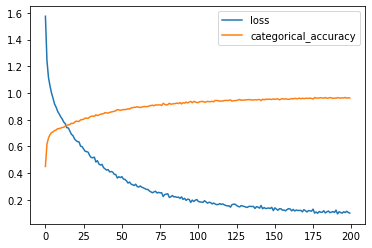

In [184]:
pd.DataFrame(history2.history).plot()

In [185]:
y_pred2 =  model_2.predict_classes(X_val_norm_19_20)
label_predict2 = label_encoder.inverse_transform(y_pred2)

In [186]:
predict_19_20 = []
n_muestras= 13
for i in range(0,int(label_predict2.shape[0]/n_muestras)):
    print('i: {} : {} '.format(i,label_predict2[i*n_muestras:i*n_muestras+n_muestras]))
    c_moda =  stat._counts(label_predict2[i*n_muestras:i*n_muestras+n_muestras])
    len_moda = len(c_moda)
    if len_moda == 1:
        moda = stat.mode(label_predict2[i*n_muestras:i*n_muestras+n_muestras])
    else:
        moda = c_moda[0][0]
        
    predict_19_20.append(moda)
    print('moda: ',moda)

i: 0 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 1 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 2 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'S' 'S' 'S' 'S'] 
moda:  S
i: 3 : ['X' 'U' 'S' 'X' 'P' 'P' 'X' 'X' 'P' 'X' 'N' 'N' 'X'] 
moda:  X
i: 4 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 5 : ['N' 'N' 'N' 'N' 'N' 'M' 'N' 'N' 'N' 'M' 'N' 'N' 'N'] 
moda:  N
i: 6 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'M' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 7 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 8 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 9 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 10 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 11 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 12 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 13 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i:

In [187]:
y_val_list = []
for i in range(0,int(y_val_19_20.shape[0]/n_muestras)):
    #print('i: {} : {} '.format(i,y_val_18_19.iloc[i*n_muestras:i*n_muestras+n_muestras]))
    y_val_list.append(stat.mode(y_val_19_20.iloc[i*n_muestras:i*n_muestras+n_muestras]))

In [188]:
ac = balanced_accuracy_score(y_val_list,predict_19_20)
print('El Balanced Accuracy para los datos de campania 19/20 :',ac)

El Balanced Accuracy para los datos de campania 19/20 : 0.6741593567251462


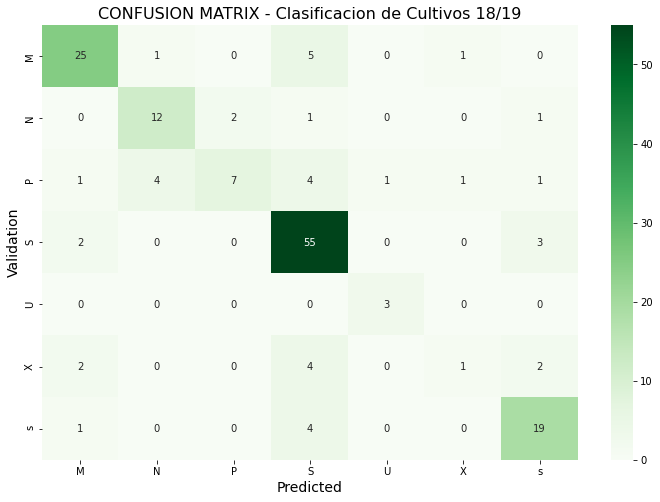

In [189]:
labels = np.unique(y_val_list)
conf_matrix = confusion_matrix(y_val_list,predict_19_20)
fig, ax = plt.subplots(figsize = (12,8))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='d',xticklabels=labels, yticklabels=labels)
plt.ylabel('Validation',size=14)
plt.xlabel('Predicted',size=14)
plt.title("CONFUSION MATRIX - Clasificacion de Cultivos 18/19", size=16);

# Modelo Final 

In [190]:
# Utilizamos el data train completo para entrenamiento y realizamos las predicciones del test para hacer la evaluacion

In [191]:
# Dataset de train y test 18/19
# s_p_train_18_19 
# s_p_test_18_19 

# Dataset de train y test 19/20
# s_p_train_19_20 
# s_p_test_19_20 

In [192]:
print('Camp.18/19 - Cantidad de puntos entrenables ',int(s_p_train_18_19.shape[0]/13))

Camp.18/19 - Cantidad de puntos entrenables  294


In [193]:
print('Camp.18/19 - Cantidad de puntos de test ',int(s_p_test_18_19.shape[0]/13))

Camp.18/19 - Cantidad de puntos de test  228


In [194]:
print('Camp.19/20 - Cantidad de puntos entrenables ',int(s_p_train_19_20.shape[0]/13))

Camp.19/20 - Cantidad de puntos entrenables  554


In [195]:
print('Camp.19/20 - Cantidad de puntos de test ',int(s_p_test_19_20.shape[0]/13))

Camp.19/20 - Cantidad de puntos de test  327


In [196]:
# Train
y_train_18_19 = s_p_train_18_19.Cultivo

X_train_18_19 = s_p_train_18_19.drop(['system:index','Cultivo','.geo','GlobalId'],axis=1, inplace=False)

# Test

Global_id_18_19 = s_p_test_18_19.GlobalId

X_test_18_19 = s_p_test_18_19.drop(['system:index','.geo','GlobalId'],axis=1, inplace=False)

In [197]:
X_test_18_19

B2_max  B2_max_1  B2_mean  B2_median  B2_min  B2_stdDev  B3_max  \
0        655       402      435        521     253        143     882   
1        606       366      406        464     240        127     860   
2        582       390      406        499     192        158     903   
3        579       283      446        488     296         99     865   
4        637       362      467        565     275        151     880   
...      ...       ...      ...        ...     ...        ...     ...   
2959     890       663      567        680     227        255    1223   
2960     896       670      561        683     226        247    1247   
2961     883       660      554        683     223        247    1223   
2962     892       668      559        686     224        249    1243   
2963     894       666      558        685     228        246    1238   

      B3_max_1  B3_mean  B3_median  ...  NDVI_mean  NDVI_median  NDVI_min  \
0          443      661        724  ...       5913         4824      3711   
1          433      643        694  ...       6186         5094      3996   
2          532      679        774  ...       6944         6024      4936   
3          325      715        787  ...       5294         5098      3931   
4          396      697        791  ...       5723         5119      3676   
...        ...      ...        ...  ...        ...          ...       ...   
2959       797      853        973  ...       4473         2462      2215   
2960       817      866        987  ...       4483         2428      2223   
2961       806      855       1006  ...       4521         2483      2201   
2962       829      867       1028  ...       4484         2438      2218   
2963       819      857        982  ...       4484         2455      2230   

      NDVI_stdDev  SAVI_max  SAVI_max_1  SAVI_mean  SAVI_median  SAVI_min  \
0            2018     12524        6959       8869         7235      5565   
1            1975     12917        6924       9278         7640      5993   
2            1898     14023        6619      10415         9035      7404   
3            1202     10909        5013       7940         7646      5896   
4            1735     11750        6236       8584         7678      5514   
...           ...       ...         ...        ...          ...       ...   
2959         2844     13883       10561       6709         3692      3322   
2960         2875     13932       10598       6723         3642      3334   
2961         2870     13929       10628       6780         3724      3301   
2962         2867     13918       10591       6726         3656      3327   
2963         2853     13909       10564       6726         3682      3345   

      SAVI_stdDev  
0            3028  
1            2962  
2            2847  
3            1803  
4            2603  
...           ...  
2959         4267  
2960         4312  
2961         4305  
2962         4301  
2963         4280  

[2964 rows x 48 columns]

In [198]:
A = X_train_18_19.iloc[0]
M = X_train_18_19.iloc[400]
N = X_train_18_19.iloc[1400]
S = X_train_18_19.iloc[3400]
aa = X_train_18_19.iloc[3400]
P = X_train_18_19.loc[y_train_18_19 =='P'].iloc[1]

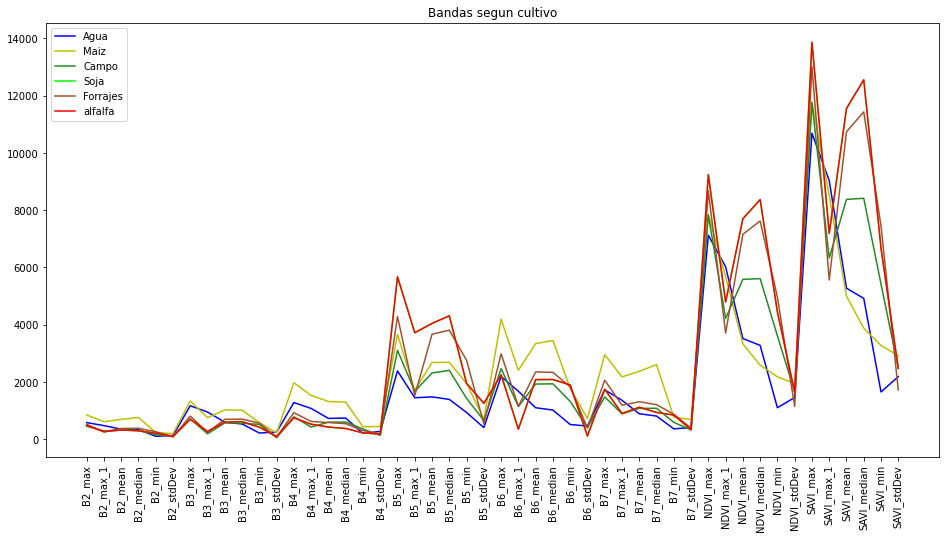

In [199]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(16,8))
plt.title('Bandas segun cultivo')
plt.plot(np.transpose(A),color='b')
plt.plot(np.transpose(M),color='y')
plt.plot(np.transpose(N),color='forestgreen')
plt.plot(np.transpose(S),color='lime')
plt.plot(np.transpose(P),color='sienna')
plt.plot(np.transpose(aa),color='red')
plt.xticks(rotation=90)
plt.legend(['Agua','Maiz','Campo','Soja','Forrajes','alfalfa'])
plt.show()

In [200]:
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train_18_19)

y_train_OHE = to_categorical(y_train_enc)

In [201]:
# Normalizamos los datos de entrenamiento

min_max_scaler = preprocessing.MinMaxScaler()

X_train_norm_18_19 = min_max_scaler.fit_transform(X_train_18_19)

X_test_norm_18_19 = min_max_scaler.transform(X_test_18_19)

In [203]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(X_train_18_19.shape[1],)))
    

    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(y_train_OHE.shape[1]))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

model_f = create_model()

metrics = [tf.keras.metrics.CategoricalAccuracy()]

model_f.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=metrics
)

history = model_f.fit(
    X_train_norm_18_19.astype(np.float32), 
    y_train_OHE.astype(np.float32),
    epochs=200,
    batch_size=128,
    
)

Train on 3822 samples
Epoch 1/200
3822/3822 [==============================] - 0s 124us/sample - loss: 1.4032 - categorical_accuracy: 0.5497
Epoch 2/200
3822/3822 [==============================] - 0s 20us/sample - loss: 1.0644 - categorical_accuracy: 0.6654
Epoch 3/200
3822/3822 [==============================] - 0s 20us/sample - loss: 0.9575 - categorical_accuracy: 0.7057
Epoch 4/200
3822/3822 [==============================] - 0s 20us/sample - loss: 0.8896 - categorical_accuracy: 0.7300
Epoch 5/200
3822/3822 [==============================] - 0s 20us/sample - loss: 0.8543 - categorical_accuracy: 0.7407
Epoch 6/200
3822/3822 [==============================] - 0s 20us/sample - loss: 0.8179 - categorical_accuracy: 0.7588
Epoch 7/200
3822/3822 [==============================] - 0s 20us/sample - loss: 0.7936 - categorical_accuracy: 0.7645
Epoch 8/200
3822/3822 [==============================] - 0s 27us/sample - loss: 0.7695 - categorical_accuracy: 0.7742
Epoch 9/200
3822/3822 [==========

3822/3822 [==============================] - 0s 21us/sample - loss: 0.2278 - categorical_accuracy: 0.9244
Epoch 138/200
3822/3822 [==============================] - 0s 21us/sample - loss: 0.2291 - categorical_accuracy: 0.9252
Epoch 139/200
3822/3822 [==============================] - 0s 21us/sample - loss: 0.2364 - categorical_accuracy: 0.9189
Epoch 140/200
3822/3822 [==============================] - 0s 22us/sample - loss: 0.2352 - categorical_accuracy: 0.9220
Epoch 141/200
3822/3822 [==============================] - 0s 21us/sample - loss: 0.2229 - categorical_accuracy: 0.9294
Epoch 142/200
3822/3822 [==============================] - 0s 21us/sample - loss: 0.2330 - categorical_accuracy: 0.9228
Epoch 143/200
3822/3822 [==============================] - 0s 21us/sample - loss: 0.2191 - categorical_accuracy: 0.9270
Epoch 144/200
3822/3822 [==============================] - 0s 21us/sample - loss: 0.2239 - categorical_accuracy: 0.9246
Epoch 145/200
3822/3822 [=============================

<AxesSubplot:>

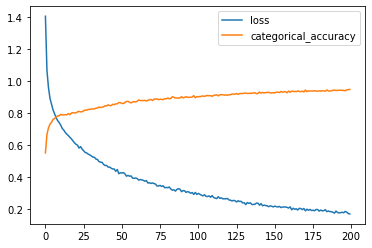

In [204]:
pd.DataFrame(history.history).plot()

In [205]:
y_pred_18_19 =  model_f.predict_classes(X_test_norm_18_19)
label_predict_18_19 = label_encoder.inverse_transform(y_pred_18_19)

In [206]:
predict_18_19 = []
n_muestras= 13
for i in range(0,int(label_predict_18_19.shape[0]/n_muestras)):
    print('i: {} : {} '.format(i,label_predict_18_19[i*n_muestras:i*n_muestras+n_muestras]))
    c_moda =  stat._counts(label_predict_18_19[i*n_muestras:i*n_muestras+n_muestras])
    len_moda = len(c_moda)
    if len_moda == 1:
        moda = stat.mode(label_predict_18_19[i*n_muestras:i*n_muestras+n_muestras])
    else:
        moda = c_moda[0][0]
        
    predict_18_19.append(moda)
    print('moda: ',moda)

i: 0 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 1 : ['M' 'M' 'S' 'M' 'S' 'M' 'M' 'M' 'M' 'S' 'M' 'M' 'S'] 
moda:  M
i: 2 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 3 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 4 : ['S' 'S' 'S' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'] 
moda:  N
i: 5 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 6 : ['P' 'P' 'P' 'P' 'P' 'S' 'S' 'P' 'S' 'S' 'P' 'P' 'P'] 
moda:  P
i: 7 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 8 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 9 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 10 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 11 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'P' 'S' 'S' 'S' 'S'] 
moda:  S
i: 12 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 13 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i:

In [207]:
Cultivo = etiquetas.Cultivo
Cultivo_id = etiquetas.CultivoId
Cultivo2Cultivoid =  dict(zip(Cultivo,Cultivo_id))
Cultivo2Cultivoid['S/M'] = '1'
print(Cultivo2Cultivoid)

{'S': 1, 's': 2, 'M': 3, 'm': 4, 'T': 5, 'C': 6, 'G': 7, 'R': 8, 'P': 9, 'N': 10, 'B': 11, 'O': 12, 'o': 13, 'E': 14, 'A': 15, 'g': 16, 't': 17, 'L': 18, 'aa': 19, 'V': 20, 'c': 21, 'a': 22, 'X': 23, 'U': 24, 'S/M': '1'}


In [208]:
predict_list_Id = [Cultivo2Cultivoid[predict_18_19[i]] for i in range(len(predict_18_19))]

In [209]:
df = pd.DataFrame(predict_list_Id)
GId= pd.DataFrame(Global_id_18_19.unique())
evaluacion_18_19 = pd.concat([GId, df ],axis=1, ignore_index=True)
evaluacion_18_19

0   1
0    351   1
1    352   3
2    178   3
3    354   3
4    465  10
..   ...  ..
223  180   3
224   19   1
225   20   1
226  116   9
227  122   1

[228 rows x 2 columns]

### Campania 19/20

In [210]:
# Train
y_train_19_20 = s_p_train_19_20.Cultivo

X_train_19_20 = s_p_train_19_20.drop(['system:index','Cultivo','.geo','GlobalId'],axis=1, inplace=False)

# Test

Global_id_19_20 = s_p_test_19_20.GlobalId

X_test_19_20 = s_p_test_19_20.drop(['system:index','.geo','GlobalId'],axis=1, inplace=False)

In [211]:
#Global_id_19_20.value_counts() 

In [212]:
label_encoder = LabelEncoder()

y_train_enc_19_20 = label_encoder.fit_transform(y_train_19_20)

y_train_OHE_19_20 = to_categorical(y_train_enc_19_20)

In [213]:
# Normalizamos los datos de entrenamiento

min_max_scaler = preprocessing.MinMaxScaler()

X_train_norm_19_20 = min_max_scaler.fit_transform(X_train_19_20)

X_test_norm_19_20 = min_max_scaler.transform(X_test_19_20)

In [215]:
def create_model_2():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(X_train_19_20.shape[1],)))
      
    model.add(tf.keras.layers.Dense(200))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(y_train_OHE_19_20.shape[1]))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

model_f2 = create_model_2()

metrics = [tf.keras.metrics.CategoricalAccuracy()]

model_f2.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=metrics
)

history2= model_f2.fit(
    X_train_norm_19_20.astype(np.float32), 
    y_train_OHE_19_20.astype(np.float32),
    epochs=200,
    batch_size=128,
    
)

Train on 7210 samples
Epoch 1/200
7210/7210 [==============================] - 1s 77us/sample - loss: 1.5909 - categorical_accuracy: 0.4071
Epoch 2/200
7210/7210 [==============================] - 0s 20us/sample - loss: 1.2879 - categorical_accuracy: 0.5581
Epoch 3/200
7210/7210 [==============================] - 0s 20us/sample - loss: 1.1571 - categorical_accuracy: 0.6232
Epoch 4/200
7210/7210 [==============================] - 0s 21us/sample - loss: 1.0899 - categorical_accuracy: 0.6607
Epoch 5/200
7210/7210 [==============================] - 0s 21us/sample - loss: 1.0597 - categorical_accuracy: 0.6655
Epoch 6/200
7210/7210 [==============================] - 0s 21us/sample - loss: 1.0244 - categorical_accuracy: 0.6800
Epoch 7/200
7210/7210 [==============================] - 0s 20us/sample - loss: 1.0065 - categorical_accuracy: 0.6886
Epoch 8/200
7210/7210 [==============================] - 0s 21us/sample - loss: 0.9926 - categorical_accuracy: 0.6856
Epoch 9/200
7210/7210 [===========

7210/7210 [==============================] - 0s 21us/sample - loss: 0.3673 - categorical_accuracy: 0.8706
Epoch 138/200
7210/7210 [==============================] - 0s 21us/sample - loss: 0.3741 - categorical_accuracy: 0.8685
Epoch 139/200
7210/7210 [==============================] - 0s 21us/sample - loss: 0.3730 - categorical_accuracy: 0.8684
Epoch 140/200
7210/7210 [==============================] - 0s 21us/sample - loss: 0.3651 - categorical_accuracy: 0.8727
Epoch 141/200
7210/7210 [==============================] - 0s 22us/sample - loss: 0.3694 - categorical_accuracy: 0.8674
Epoch 142/200
7210/7210 [==============================] - 0s 21us/sample - loss: 0.3693 - categorical_accuracy: 0.8648
Epoch 143/200
7210/7210 [==============================] - 0s 20us/sample - loss: 0.3543 - categorical_accuracy: 0.8731
Epoch 144/200
7210/7210 [==============================] - 0s 21us/sample - loss: 0.3673 - categorical_accuracy: 0.8678
Epoch 145/200
7210/7210 [=============================

<AxesSubplot:>

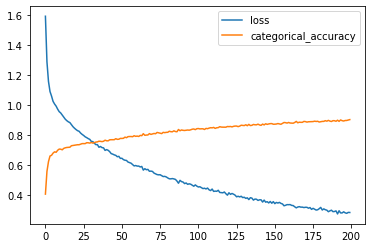

In [216]:
pd.DataFrame(history2.history).plot()

In [217]:
y_pred_19_20 =  model_f2.predict_classes(X_test_norm_19_20)
label_predict_19_20 = label_encoder.inverse_transform(y_pred_19_20)

In [218]:
# Calculo la moda de las muestras para un mismo campo

predict_19_20 = []
n_muestras= 13
for i in range(0,int(label_predict_19_20.shape[0]/n_muestras)):
    print('i: {} : {} '.format(i,label_predict_19_20[i*n_muestras:i*n_muestras+n_muestras]))
    c_moda =  stat._counts(label_predict_19_20[i*n_muestras:i*n_muestras+n_muestras])
    len_moda = len(c_moda)
    if len_moda == 1:
        moda = stat.mode(label_predict_19_20[i*n_muestras:i*n_muestras+n_muestras])
    else:
        moda = c_moda[0][0]
        
    predict_19_20.append(moda)
    print('moda: ',moda)

i: 0 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 1 : ['s' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's'] 
moda:  s
i: 2 : ['s' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's'] 
moda:  s
i: 3 : ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P'] 
moda:  P
i: 4 : ['P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P' 'P'] 
moda:  P
i: 5 : ['M' 'P' 'P' 'P' 'P' 'M' 'N' 'P' 'N' 'P' 'S' 'P' 'P'] 
moda:  P
i: 6 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 7 : ['s' 's' 'S' 's' 's' 's' 's' 's' 's' 's' 'S' 's' 's'] 
moda:  s
i: 8 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 9 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 10 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 11 : ['M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M'] 
moda:  M
i: 12 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i: 13 : ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'] 
moda:  S
i:

In [219]:
predict_list_Id2 = [Cultivo2Cultivoid[predict_19_20[i]] for i in range(len(predict_19_20))]

In [220]:
df = pd.DataFrame(predict_list_Id2)
GId= pd.DataFrame(Global_id_19_20.unique())
evaluacion_19_20 = pd.concat([GId, df ],axis=1, ignore_index=True)
evaluacion_19_20

0  1
0     930  1
1     931  2
2     934  2
3     946  9
4     954  9
..    ... ..
322  1241  3
323  1286  3
324  1038  2
325  1050  3
326  1337  1

[327 rows x 2 columns]

### CSV de Evaluacion con campania 18/19 y 19/20

In [221]:
submit = pd.concat([evaluacion_18_19, evaluacion_19_20 ],axis=0, ignore_index=True)

In [222]:
submit = submit.sort_values(by=0, ascending=True)
submit

0   1
154     2   3
114     3   3
211     5   3
99      8   9
77     11  10
..    ...  ..
526  1438  23
418  1443  10
419  1445  24
420  1450  24
421  1454  10

[555 rows x 2 columns]

In [672]:
submit2.to_csv('submit.csv',index=False, header=False)